## Gaussian Localization -- Condensed

In [55]:
import os
import scipy.signal as sp
%matplotlib inline
import sys  
import importlib

sys.path.append('../Libraries') # adjust as needed

# load the local library
import sdc_config3 as sdc
import gaussplat as gp

# array compute and plotting
import torch
import numpy as np
import matplotlib.pyplot as plt
import imageio

# for gaussian functions and plotting
from mpl_toolkits.mplot3d import Axes3D
from torch.distributions.multivariate_normal import MultivariateNormal


In [56]:
importlib.reload(gp)

<module 'gaussplat' from 'c:\\Users\\kira_\\OneDrive\\Documents\\PhD\\Classes\\CompImaging\\FinalProject\\spectralmicroscope_gaussiansplatting\\GaussSplatting\\../Libraries\\gaussplat.py'>

### Forward model parameters
Filter mask, PSF

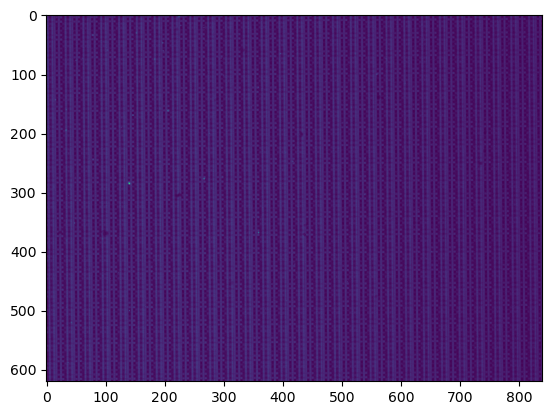

Shape of the filter array: torch.Size([620, 840, 45])


In [57]:
# Filter mask

# Load filter calibration data
data_folder = '../Calibration_Data'
file_name = 'filterCal_every2nm_darksub_2021-02-03.mat'

# Import the filter stack from the specified file
wavelengths, ci, filter_stack = sdc.importFilterStack(data_folder, file_name)

# Adjust CI values for zero-based indexing
# Define the cropped part of the image
ci_adjusted = [ci[0] - 1, ci[1] - 1, ci[2], ci[3]]

# Define wavelength sampling parameters
wavelength_min = 450
wavelength_max = 800
wavelength_step = 8

# Create a new array of wavelengths
wavelength_new = np.arange(wavelength_min, wavelength_max + wavelength_step, wavelength_step)

# Sum the filter array over the specified wavelength range
filt_arr = sdc.sumFilterArray(filter_stack, wavelengths, wavelength_min, wavelength_max, wavelength_step)
filt_arr = filt_arr / np.amax(filt_arr) # normalize
m = torch.tensor(filt_arr) # make tensor

# Plot the sum of the filter array across the last dimension
plt.figure()
plt.imshow(torch.sum(m, axis=2))
plt.show()

# Print the shape of the tensor
print("Shape of the filter array:", m.shape)

# Extract dimensions for further processing
# NL is the number of wavelengths
NY, NX, NL = m.shape

torch.Size([620, 840])


C:\Users\kira_\AppData\Local\Temp\ipykernel_38764\1925681583.py:5: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))


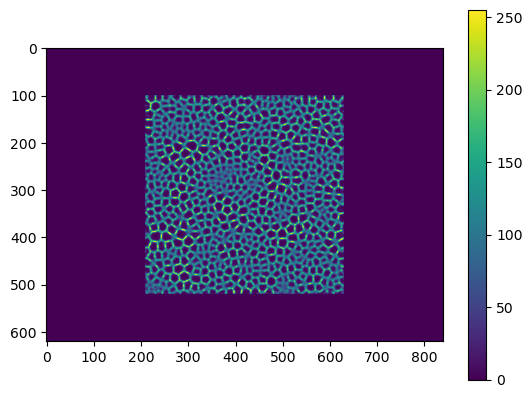

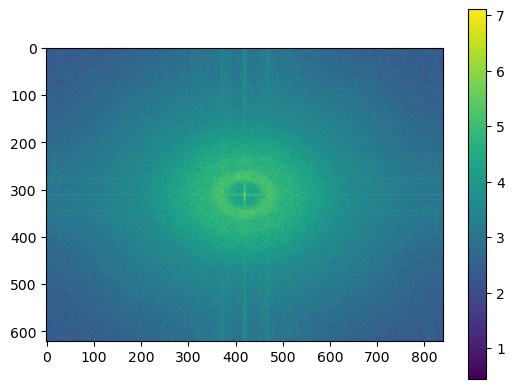

In [58]:
# PSF

datafolder = '../Calibration_Data'
fname = 'psf_090_1.png'
psf = torch.from_numpy(imageio.imread(os.path.join(datafolder, fname)))

 # Expand the PSF to match the shape of the filter array
pad_h = (m.shape[0] - psf.shape[0]) // 2
pad_w = (m.shape[1] - psf.shape[1]) // 2
padding = (pad_w, m.shape[1] - psf.shape[1] - pad_w, pad_h, m.shape[0] - psf.shape[0] - pad_h)
h = torch.nn.functional.pad(psf, padding, mode='constant', value=0)
print(h.shape)

plt.figure()
plt.imshow(h)
plt.colorbar()
plt.show()

hf = torch.fft.fftshift(torch.fft.fft2(h,dim=(0,1)))
plt.imshow(torch.log10(torch.abs(hf)))
plt.colorbar()
plt.show()

### Construct ground truth gaussian object

In [88]:
# Ground truth parameters -- must be floats
muy = 300.0
mux = 400.0
mul = 0.0
sigy = 10.0
sigx = 10.0
sigl = 1.0
NY, NX, NL = m.shape

In [89]:
# Create gaussian object and 3D array
g_ground = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)
g3d = g_ground.createPixelGauss(NY,NX,NL)

### Get ground truth measurement

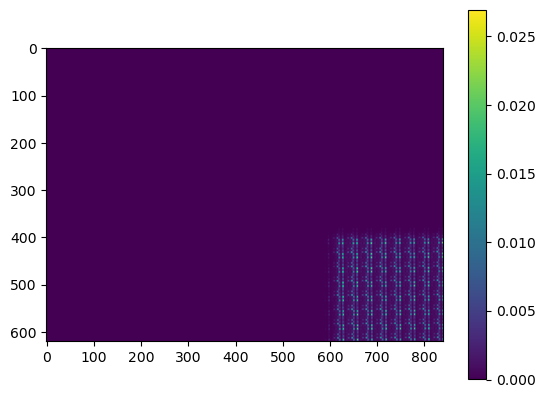

In [90]:
# Pad PSF
h_padded = sdc.pad(h) # double the size of h
h_padded_3d = sdc.make3d(h_padded, NL) # copy h NL times along the 3rd dimension
hf_padded_3d = sdc.fft3d(h_padded_3d) # take fft along dim 0 and 1

# Pad X
g3d_padded = sdc.pad(g3d.detach())
g3d_padded = g3d_padded.cpu() # added to put all tensors on cpu


# Get measurement
gt_measurement = sdc.forwardmodel3d(g3d_padded, hf_padded_3d, m)
gt_measurement = gt_measurement/torch.norm(gt_measurement) # normalize
plt.figure()
plt.imshow(gt_measurement.detach().numpy())
plt.colorbar()
plt.show() 

### Initialize random gaussian guess

In [85]:
# Define a Gaussian object with initialized values

# Initialized guess parameters -- must be floats
muy_init = 10.
mux_init = 10.
mul_init = 0.
sigy_init = 10.
sigx_init = 10.
sigl_init = 1.
lr_init = 2 #0.01
NY, NX, NL = m.shape

g_init = gp.GaussObject(muy_init,mux_init,mul_init,sigy_init,sigx_init,sigl_init,learningrate=lr_init)

gaussObject(mu_x = 10.0, mu_y = 10.0, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)


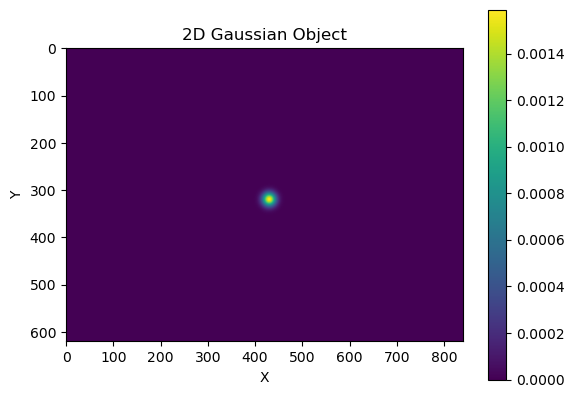

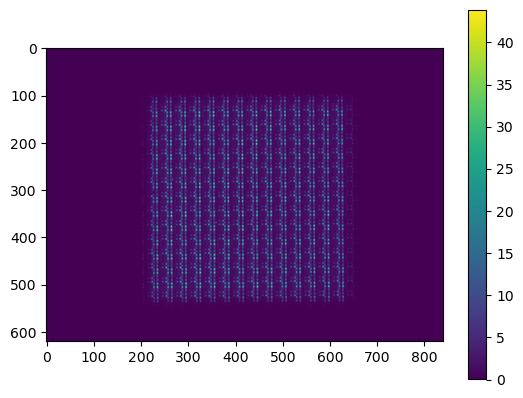

In [86]:
# Display the initial Gaussian guess and its measurement

# Object
print(g_init)
g_init.plot(coords,NY,NX)

# Measurement
g_init_meas = gp.forwardSingleGauss(g_init, NX, NY, NL, h, m)
plt.figure()
plt.imshow(g_init_meas.detach().numpy())
plt.colorbar()
plt.show() 

### Gradient descent

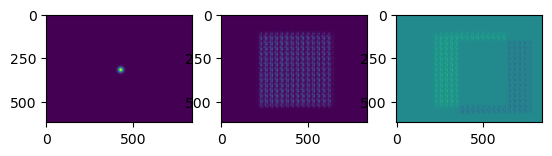

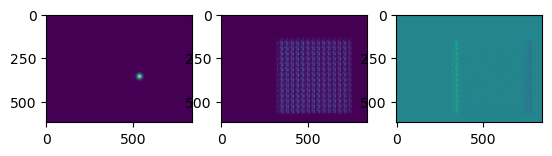

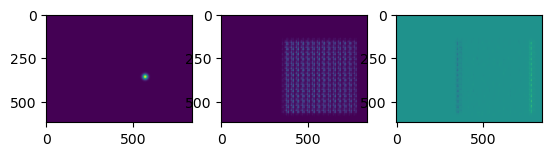

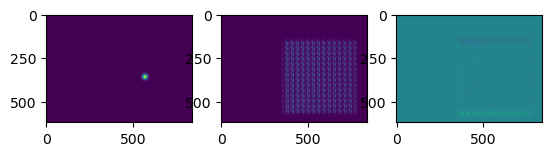

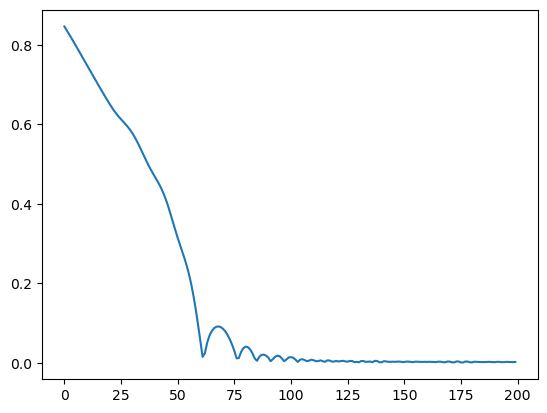

In [20]:
max_iters = 200
thresh = 1e-5
loss_GD = []
params_GD = {'mux':[],'muy':[]}

for k2 in range(max_iters):
    # compute forward model
    best = torch.zeros_like(h)
    obj = torch.zeros_like(h)
    for k in np.arange(1):
        best =  best + gp.forwardSingleGauss(g_init, NX, NY, NL, h, m)  # compute individual measurements
        obj = obj + g_init.computeValues(coords, NY, NX)

    best = best/torch.norm(best)
    
    # plot the beads every 10th iter
    if k2%50 == 0:
        plt.figure()
        plt.subplot(1,3,1)
        plt.imshow(obj.detach().numpy())
        plt.subplot(1,3,2)
        plt.imshow(best.detach().numpy())
        plt.subplot(1,3,3)
        plt.imshow((best-gt_measurement).detach().numpy())
        plt.show()
    
    # compute loss
    loss = torch.norm(best - gt_measurement)
    loss_GD.append(loss.item())
    loss.backward()

    # update gaussian parameters
    for k in range(1):
        g_init.gradStep()
        g_init.zeroGrad()
        
plt.figure()
plt.plot(loss_GD)       
    

Gradient descent, with saved .gif of difference across process

In [32]:
#imports for making a gif
from PIL import Image
import io

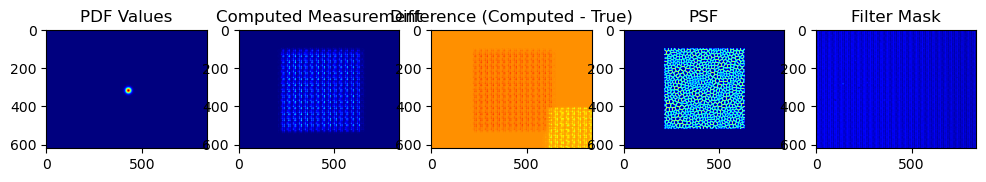

gaussObject(mu_x = 10.0, mu_y = 10.0, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 11.999974250793457, mu_y = 11.999917984008789, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 14.00133991241455, mu_y = 14.000107765197754, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 16.00592613220215, mu_y = 16.000673294067383, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 18.01573944091797, mu_y = 18.002288818359375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 20.032611846923828, mu_y = 20.006330490112305, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 22.057973861694336, mu_y = 22.014822006225586, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], r

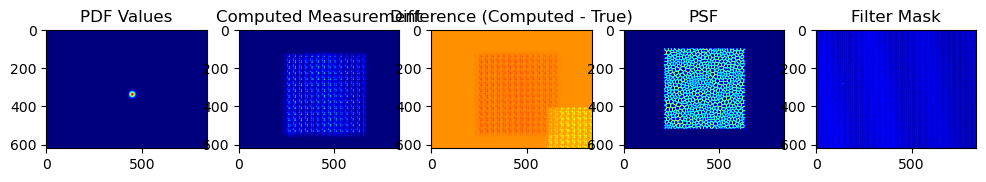

gaussObject(mu_x = 30.24839210510254, mu_y = 30.151996612548828, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 32.31106185913086, mu_y = 32.227848052978516, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 34.37384033203125, mu_y = 34.32468795776367, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 36.43320846557617, mu_y = 36.443084716796875, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 38.48641586303711, mu_y = 38.58263397216797, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 40.532310485839844, mu_y = 40.74188232421875, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 42.57194900512695, mu_y = 42.91836166381836, mu_l = 0.0), cov = tensor([[100.,   0.],
   

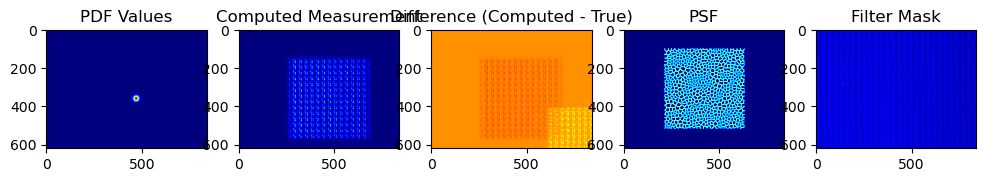

gaussObject(mu_x = 50.75597381591797, mu_y = 51.735382080078125, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 52.83479690551758, mu_y = 53.95892333984375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 54.9336051940918, mu_y = 56.1929931640625, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 57.052330017089844, mu_y = 58.44222640991211, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 59.1888542175293, mu_y = 60.711727142333984, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 61.3394660949707, mu_y = 63.005775451660156, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 63.4996223449707, mu_y = 65.32689666748047, mu_l = 0.0), cov = tensor([[100.,   0.],
        

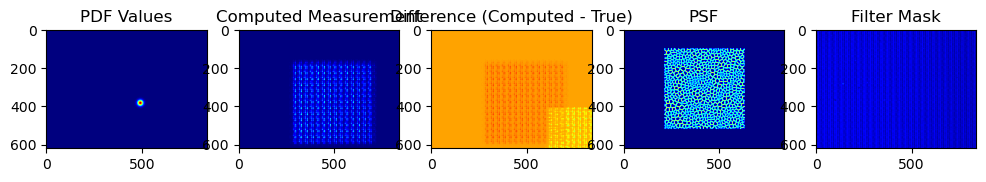

gaussObject(mu_x = 72.17158508300781, mu_y = 74.85768127441406, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 74.34891510009766, mu_y = 77.28003692626953, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 76.53839111328125, mu_y = 79.70703125, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 78.74656677246094, mu_y = 82.13545989990234, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 80.9795913696289, mu_y = 84.5653305053711, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 83.24183654785156, mu_y = 86.999267578125, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 85.53474426269531, mu_y = 89.4404525756836, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100

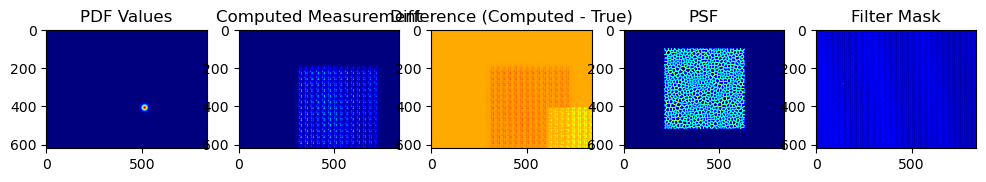

gaussObject(mu_x = 94.92750549316406, mu_y = 99.2352066040039, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 97.29381561279297, mu_y = 101.64097595214844, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 99.65550994873047, mu_y = 103.99828338623047, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 102.01203918457031, mu_y = 106.29220581054688, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 104.36628723144531, mu_y = 108.51193237304688, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 106.72354888916016, mu_y = 110.6520004272461, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 109.09008026123047, mu_y = 112.7126235961914, mu_l = 0.0), cov = tensor([[100.,   0.],


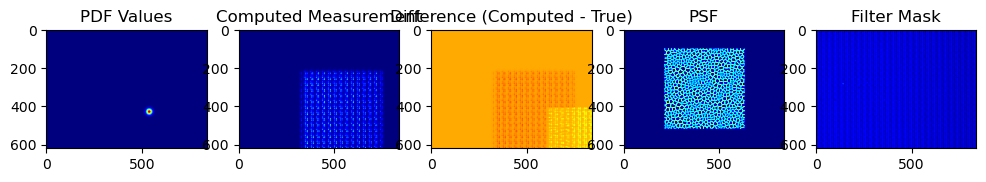

gaussObject(mu_x = 118.71637725830078, mu_y = 120.31421661376953, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 121.15196990966797, mu_y = 122.10710144042969, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 123.58547973632812, mu_y = 123.87440490722656, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 126.0099105834961, mu_y = 125.62016296386719, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 128.4214630126953, mu_y = 127.34583282470703, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 130.8207244873047, mu_y = 129.05126953125, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 133.21263122558594, mu_y = 130.73583984375, mu_l = 0.0), cov = tensor([[100.,   0.],
  

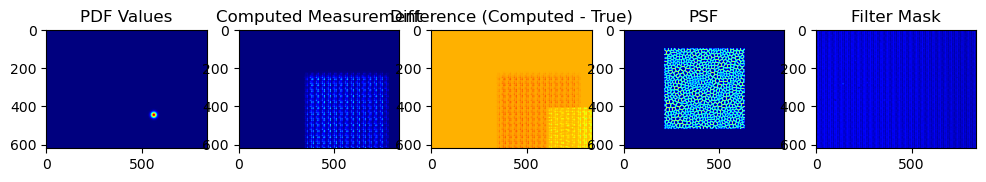

gaussObject(mu_x = 142.87045288085938, mu_y = 137.2696075439453, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 145.33529663085938, mu_y = 138.86085510253906, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 147.81808471679688, mu_y = 140.4437255859375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 150.3109893798828, mu_y = 142.02581787109375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 152.8048858642578, mu_y = 143.616455078125, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 155.29196166992188, mu_y = 145.2260284423828, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 157.76797485351562, mu_y = 146.86500549316406, mu_l = 0.0), cov = tensor([[100.,   0.],


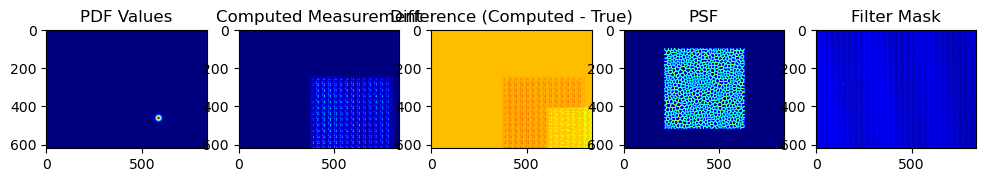

gaussObject(mu_x = 167.63316345214844, mu_y = 153.87416076660156, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 170.12937927246094, mu_y = 155.75450134277344, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 172.650146484375, mu_y = 157.67945861816406, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 175.19480895996094, mu_y = 159.64073181152344, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 177.75775146484375, mu_y = 161.62962341308594, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 180.32965087890625, mu_y = 163.63888549804688, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 182.89993286132812, mu_y = 165.66397094726562, mu_l = 0.0), cov = tensor([[100.,   

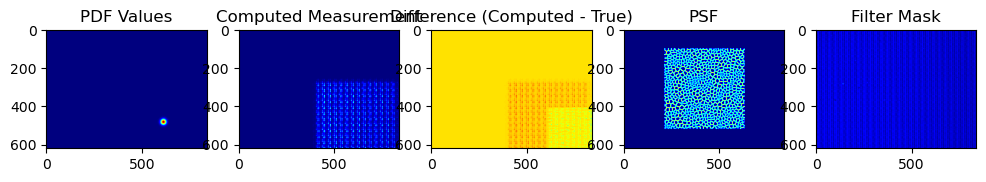

gaussObject(mu_x = 193.04837036132812, mu_y = 173.9524383544922, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 195.55868530273438, mu_y = 176.1125030517578, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 198.06881713867188, mu_y = 178.33538818359375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 200.58177185058594, mu_y = 180.63461303710938, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 203.09585571289062, mu_y = 183.01763916015625, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 205.60382080078125, mu_y = 185.48281860351562, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 208.0935516357422, mu_y = 188.01795959472656, mu_l = 0.0), cov = tensor([[100.,   0

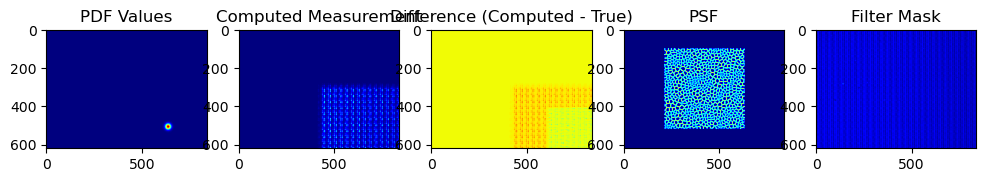

gaussObject(mu_x = 217.58998107910156, mu_y = 198.4075469970703, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 219.80711364746094, mu_y = 201.00173950195312, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 221.96229553222656, mu_y = 203.6172637939453, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 224.06100463867188, mu_y = 206.2812957763672, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 226.10816955566406, mu_y = 209.01622009277344, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 228.10723876953125, mu_y = 211.8336639404297, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 230.06040954589844, mu_y = 214.7325897216797, mu_l = 0.0), cov = tensor([[100.,   0.]

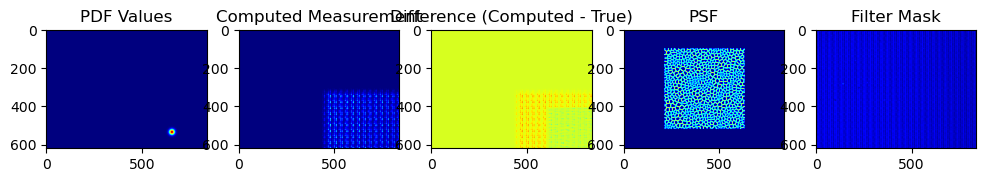

gaussObject(mu_x = 237.43096923828125, mu_y = 226.75909423828125, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 239.1583251953125, mu_y = 229.7621612548828, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 240.83682250976562, mu_y = 232.7632598876953, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 242.4688720703125, mu_y = 235.79348754882812, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 244.0607147216797, mu_y = 238.88633728027344, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 245.6217041015625, mu_y = 242.06309509277344, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 247.16241455078125, mu_y = 245.32452392578125, mu_l = 0.0), cov = tensor([[100.,   0.],

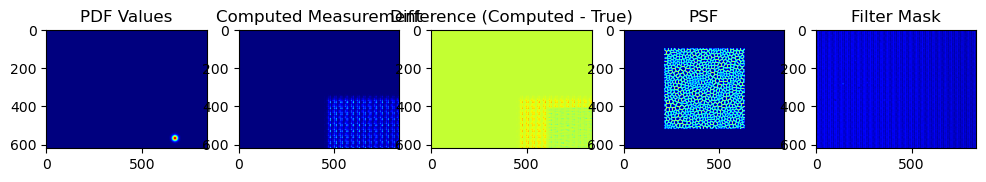

gaussObject(mu_x = 253.315673828125, mu_y = 258.6966247558594, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 254.90133666992188, mu_y = 262.02606201171875, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 256.5259094238281, mu_y = 265.3817138671875, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 258.1941223144531, mu_y = 268.79925537109375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 259.9054260253906, mu_y = 272.3017883300781, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 261.65576171875, mu_y = 275.89251708984375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 263.4401550292969, mu_y = 279.55511474609375, mu_l = 0.0), cov = tensor([[100.,   0.],
     

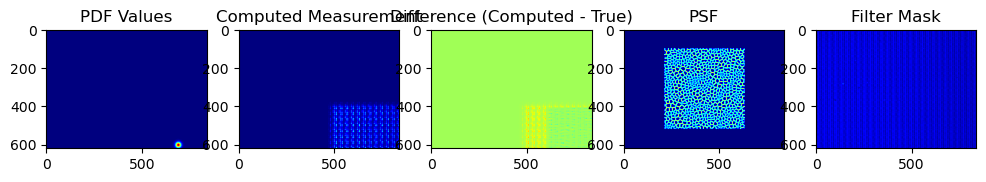

gaussObject(mu_x = 270.787841796875, mu_y = 294.3443298339844, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 272.63934326171875, mu_y = 298.01953125, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 274.4939270019531, mu_y = 301.684326171875, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 276.3599548339844, mu_y = 305.2875061035156, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 278.2472229003906, mu_y = 308.71453857421875, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 280.1655578613281, mu_y = 311.80389404296875, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 282.12591552734375, mu_y = 314.4104919433594, mu_l = 0.0), cov = tensor([[100.,   0.],
        [ 

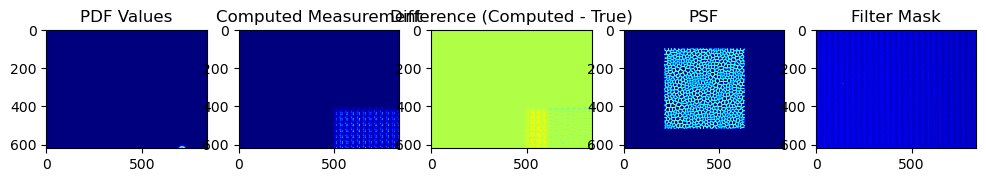

gaussObject(mu_x = 290.5829772949219, mu_y = 319.4021911621094, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 292.8601989746094, mu_y = 319.4556579589844, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 295.18365478515625, mu_y = 319.1212158203125, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 297.5350341796875, mu_y = 318.4400939941406, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 299.8956604003906, mu_y = 317.45269775390625, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 302.25091552734375, mu_y = 316.20208740234375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 304.5940856933594, mu_y = 314.738037109375, mu_l = 0.0), cov = tensor([[100.,   0.],
    

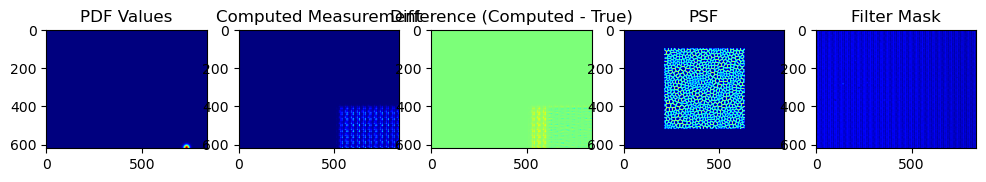

gaussObject(mu_x = 314.0572509765625, mu_y = 308.1268310546875, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 316.5513916015625, mu_y = 306.7065734863281, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 319.1327209472656, mu_y = 305.5388488769531, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 321.8018493652344, mu_y = 304.6726989746094, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 324.5456848144531, mu_y = 304.1318359375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 327.3397216796875, mu_y = 303.9169616699219, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 330.154541015625, mu_y = 304.0102233886719, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  

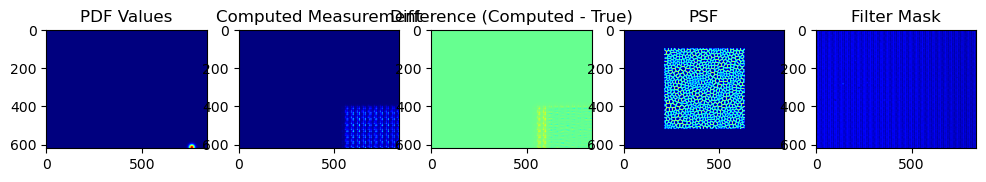

gaussObject(mu_x = 341.39825439453125, mu_y = 306.6629943847656, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 344.29534912109375, mu_y = 307.609130859375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 347.2897033691406, mu_y = 308.5283508300781, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 350.3983154296875, mu_y = 309.35003662109375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 353.6183776855469, mu_y = 310.0149230957031, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 356.9267578125, mu_y = 310.4809265136719, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 360.2865905761719, mu_y = 310.7247314453125, mu_l = 0.0), cov = tensor([[100.,   0.],
        

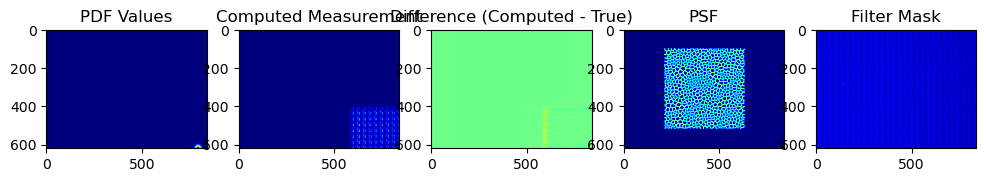

gaussObject(mu_x = 373.9515686035156, mu_y = 309.5968322753906, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 377.56390380859375, mu_y = 308.95928955078125, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 381.3164367675781, mu_y = 308.3069763183594, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 385.1875305175781, mu_y = 307.7269592285156, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 389.1092529296875, mu_y = 307.30267333984375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 392.9720153808594, mu_y = 307.0946044921875, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 396.6534423828125, mu_y = 307.1227111816406, mu_l = 0.0), cov = tensor([[100.,   0.],
    

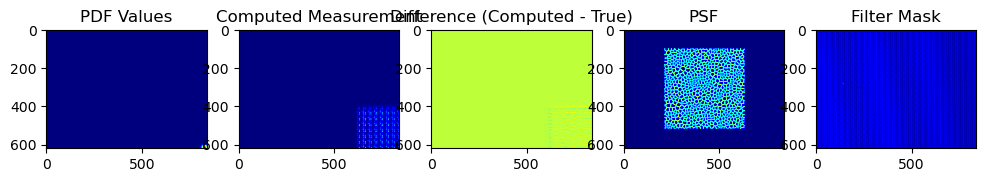

gaussObject(mu_x = 407.885009765625, mu_y = 308.61358642578125, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 409.4968566894531, mu_y = 308.946533203125, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 410.555419921875, mu_y = 309.1457214355469, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 411.07672119140625, mu_y = 309.195068359375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 411.1029968261719, mu_y = 309.1028137207031, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 410.6930236816406, mu_y = 308.8968505859375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 409.91510009765625, mu_y = 308.6191101074219, mu_l = 0.0), cov = tensor([[100.,   0.],
        

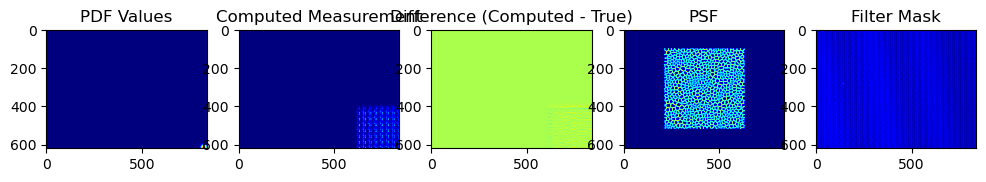

gaussObject(mu_x = 404.6049499511719, mu_y = 307.7482604980469, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 403.0820617675781, mu_y = 307.7585754394531, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 401.5985107421875, mu_y = 307.8681640625, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 400.1955871582031, mu_y = 308.0492858886719, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 398.9052429199219, mu_y = 308.263671875, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 397.751953125, mu_y = 308.4705810546875, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 396.7543640136719, mu_y = 308.6347351074219, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100

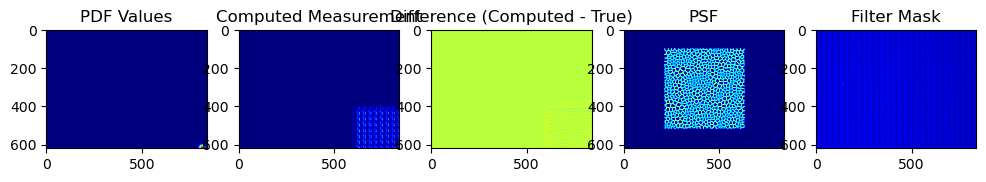

gaussObject(mu_x = 394.51513671875, mu_y = 308.6011962890625, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 394.3956298828125, mu_y = 308.4681396484375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 394.4347839355469, mu_y = 308.33245849609375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 394.61590576171875, mu_y = 308.21881103515625, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 394.919189453125, mu_y = 308.1454162597656, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 395.3228454589844, mu_y = 308.1213684082031, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 395.8041687011719, mu_y = 308.1457214355469, mu_l = 0.0), cov = tensor([[100.,   0.],
       

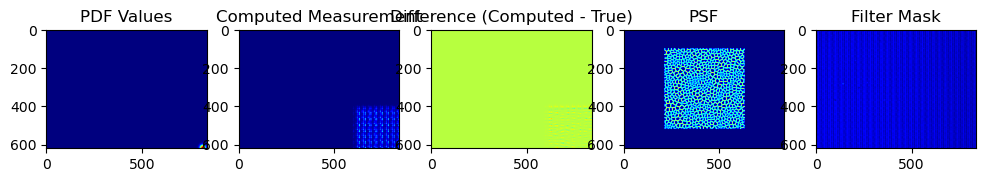

gaussObject(mu_x = 398.0716552734375, mu_y = 308.4555969238281, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 398.6287841796875, mu_y = 308.5006408691406, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 399.1511535644531, mu_y = 308.5104064941406, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 399.6273193359375, mu_y = 308.4855651855469, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 400.0481872558594, mu_y = 308.43353271484375, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 400.4069519042969, mu_y = 308.3663635253906, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 400.6991271972656, mu_y = 308.298095703125, mu_l = 0.0), cov = tensor([[100.,   0.],
       

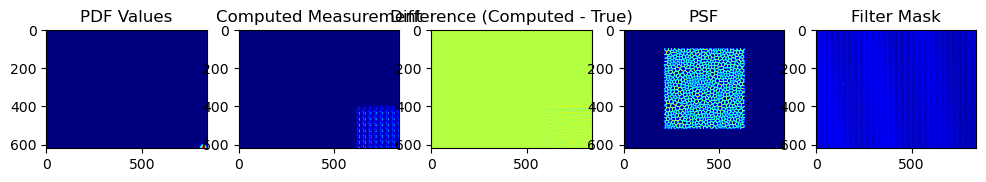

gaussObject(mu_x = 401.18798828125, mu_y = 308.2148132324219, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 401.1539611816406, mu_y = 308.2509460449219, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 401.0685119628906, mu_y = 308.2976989746094, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 400.93914794921875, mu_y = 308.344970703125, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 400.7740478515625, mu_y = 308.3834533691406, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 400.5816345214844, mu_y = 308.40655517578125, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 400.3703308105469, mu_y = 308.411376953125, mu_l = 0.0), cov = tensor([[100.,   0.],
        [

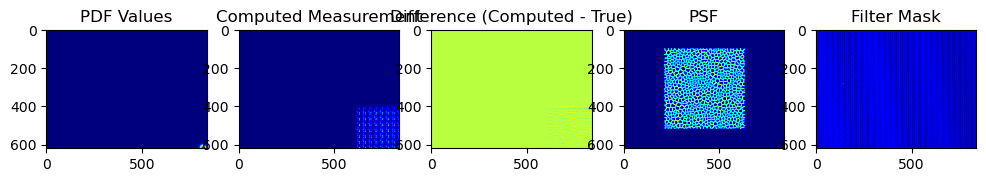

gaussObject(mu_x = 399.4914855957031, mu_y = 308.31121826171875, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 399.2962341308594, mu_y = 308.2878112792969, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 399.120849609375, mu_y = 308.2760314941406, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 398.9686584472656, mu_y = 308.27740478515625, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 398.8420104980469, mu_y = 308.2906188964844, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 398.7422180175781, mu_y = 308.3120422363281, mu_l = 0.0), cov = tensor([[100.,   0.],
        [  0., 100.]], requires_grad=True)
gaussObject(mu_x = 398.669677734375, mu_y = 308.3367004394531, mu_l = 0.0), cov = tensor([[100.,   0.],
       

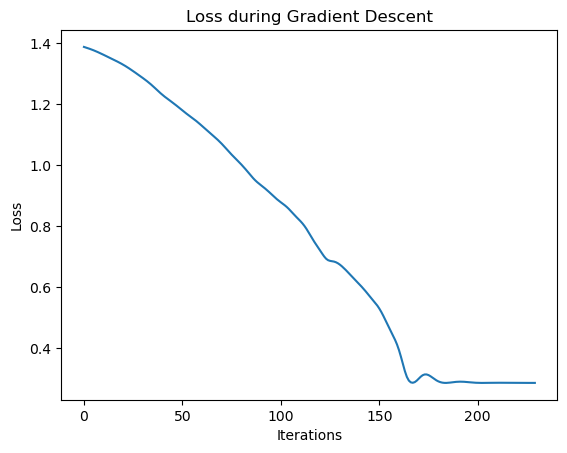

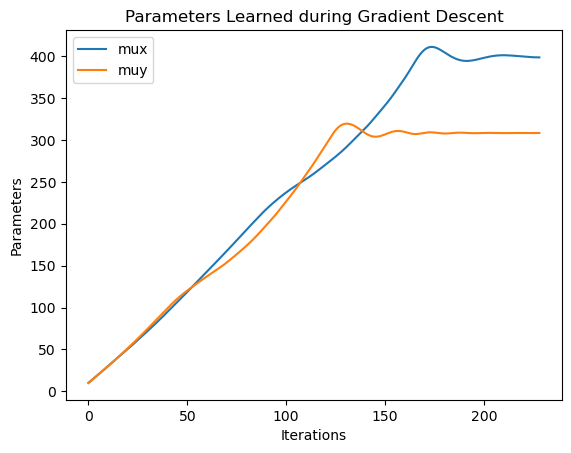

In [ ]:
# Set number of iterations and initialize the loss tracker
# Need to rerun initialize random gaussian guess cells every time **
max_iters = 300
thresh = 1e-6
loss_GD = []
params_GD = {'mux':[],'muy':[]}
frames = []

# Define figure size and DPI for consistent frame sizes
fig_size = (6, 6)
dpi = 100
#colorbar ranges
vmin = -0.01
vmax = 0.01

# Optimization loop
for i in range(max_iters):
    # Compute forward model using the current Gaussian parameters
    computed_measurement = gp.forwardSingleGauss(g_init, NX, NY, NL, h, m)
    computed_measurement = computed_measurement / torch.norm(computed_measurement) # normalize
    
    # Compute PDF values based on the Gaussian parameters
    computed_values = g_init.computeValues(coords, NY, NX)
    
    # Plot the results every x iterations (optional)
    if i % 10 == 0:
        plt.figure(figsize=(12, 12))
        plt.subplot(1, 5, 1)
        plt.imshow(computed_values.detach().cpu().numpy(), cmap='jet')
        plt.title("PDF Values")

        plt.subplot(1, 5, 2)
        plt.imshow(computed_measurement.detach().cpu().numpy(), cmap='jet')
        plt.title("Computed Measurement")

        plt.subplot(1, 5, 3)
        plt.imshow((computed_measurement - gt_measurement).detach().cpu().numpy(), cmap='jet')
        plt.title("Difference (Computed - True)")
        
        plt.subplot(1, 5, 4)
        plt.imshow((h).detach().cpu().numpy(), cmap='jet')
        plt.title("PSF")
        
        plt.subplot(1, 5, 5)
        plt.imshow((torch.sum(m, axis=2)).detach().cpu().numpy(), cmap='jet')
        plt.title("Filter Mask")
        
        plt.show()


        #gif portion for third frame (difference)
        fig = plt.figure(figsize=fig_size, dpi=dpi)
        # Create axis with fixed position
        ax = plt.axes([0.1, 0.1, 0.75, 0.85])  # [left, bottom, width, height]
        im = ax.imshow((computed_measurement - gt_measurement).detach().cpu().numpy(), 
                      cmap='jet',
                      vmin=vmin,
                      vmax=vmax,
                      extent=[0, 800, 600, 0])  # Match your image dimensions
        ax.set_title(f"Difference (Computed - True)\nIteration {i}")
        
        # Add colorbar with fixed position
        cax = plt.axes([0.87, 0.1, 0.03, 0.85])
        plt.colorbar(im, cax=cax)
        
        # Convert plot to PIL Image
        buf = io.BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight', dpi=dpi)
        buf.seek(0)
        image = Image.open(buf)
        image = image.convert("RGB")
        
        # If this is the first frame, use its size as reference
        if not frames:
            first_size = image.size
        else:
            image = image.resize(first_size, Image.Resampling.LANCZOS)
        
        frames.append(image)
        
        # Close both the buffer and the figure
        buf.close()
        plt.close(fig)

    
    # Store the loss (difference between computed measurement and true measurement)
    loss = torch.norm(computed_measurement - gt_measurement)
    loss_GD.append(loss.item())
    if i > 0: # stop if loss isn't changing
        if np.abs(loss_GD[i] - loss_GD[i-1]) < thresh:
            break
    
    # Store the learned parameters
    params_GD['mux'].append(float(g_init.mux.detach().numpy()))        #g_init.mux.detach().numpy())
    params_GD['muy'].append(float(g_init.muy.detach().numpy()))        #g_init.muy.detach().numpy())
    print(g_init) 
    
    # Perform a gradient step to update Gaussian parameters
    loss.backward()
    g_init.gradStep()
    
    # Zero the gradients after the update
    g_init.zeroGrad()



#save Gif
frames[0].save(
    'optimization_progress.gif',
    save_all=True,
    append_images=frames[1:],
    duration=500,  # Increased duration since we have fewer frames
    loop=0,        # 0 means loop forever
    optimize=False)  # Don't try to optimize the frames
    


# Plot the loss over iterations
plt.figure()
plt.plot(loss_GD)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss during Gradient Descent')
plt.show()

# Plot the change in learned parameters over iterations
plt.figure()
plt.plot(params_GD['mux'], label='mux')
plt.plot(params_GD['muy'], label='muy')
plt.legend()
plt.xlabel('Iterations')
plt.ylabel('Parameters')
plt.title('Parameters Learned during Gradient Descent')
plt.show()

## Debugging

All debugging code can go below

### Compare sdc vs. gaussplat measurements
Generally useful to plot as we make updates to the forward models

In [261]:
# Gaussian parameters -- must be floats
muy = 50.
mux = 150.
mul = 0.
sigy = 10.
sigx = 10.
sigl = 1.
NY, NX, NL = m.shape

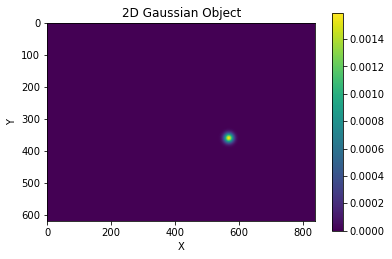

In [262]:
# Create gaussian object and 3D array
g_test = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)
g3d_test = g_test.createPixelGauss(NY,NX,NL)
g_test.plot(coords, NY, NX)

In [263]:
# Pixel forward model

# Pad PSF
h_padded = sdc.pad(h) # double the size of h
h_padded_3d = sdc.make3d(h_padded, NL) # copy h NL times along the 3rd dimension
hf_padded_3d = sdc.fft3d(h_padded_3d) # take fft along dim 0 and 1

# Pad X
g3d_test_padded = sdc.pad(g3d_test.detach())

# Get measurement
g3_test_measurement = sdc.forwardmodel3d(g3d_test_padded, hf_padded_3d, m)
g3_test_measurement = g3_test_measurement/torch.norm(g3_test_measurement) # normalize

In [264]:
# Gaussian forward model

# Get measurement
g_test_measurement = gp.forwardSingleGauss(g_test, NX, NY, NL, h, m)
g_test_measurement = g_test_measurement/torch.norm(g_test_measurement)

In [265]:
# Get difference
g_test_diff = g3_test_measurement - g_test_measurement
mse = torch.norm(g_test_diff)

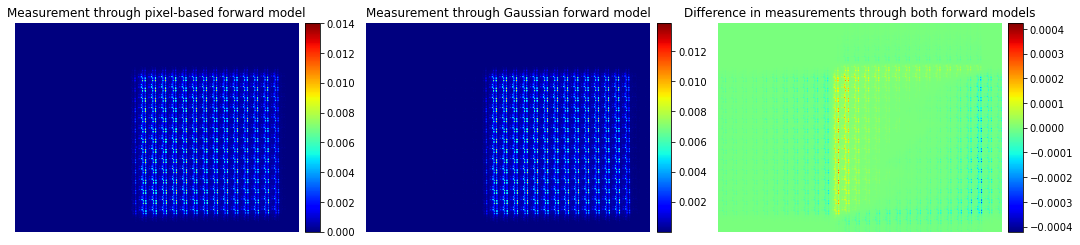

MSE:  0.018344340993110563


In [266]:
# Plot difference and get MSE

from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create a figure with 1 row and 3 columns of subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Adjust `figsize` as needed for better visuals

im1 = axes[0].imshow(g3_test_measurement.detach().numpy(), cmap='jet', 
                     vmin=g3_test_measurement.min().item(), 
                     vmax=g3_test_measurement.max().item())
axes[0].set_title("Measurement through pixel-based forward model")
axes[0].axis('off')
divider1 = make_axes_locatable(axes[0])
cax1 = divider1.append_axes("right", size="5%", pad=0.1)  # Adjust size and pad for appearance
fig.colorbar(im1, cax=cax1)

im2 = axes[1].imshow(g_test_measurement.detach().numpy(), cmap='jet', 
                     vmin=g_test_measurement.min().item(), 
                     vmax=g_test_measurement.max().item())
axes[1].set_title("Measurement through Gaussian forward model")
axes[1].axis('off')
divider2 = make_axes_locatable(axes[1])
cax2 = divider2.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im2, cax=cax2)

im3 = axes[2].imshow(g_test_diff.detach().numpy(), cmap='jet', 
                     vmin=g_test_diff.min().item(), 
                     vmax=g_test_diff.max().item())
axes[2].set_title("Difference in measurements through both forward models")
axes[2].axis('off')
divider3 = make_axes_locatable(axes[2])
cax3 = divider3.append_axes("right", size="5%", pad=0.1)
fig.colorbar(im3, cax=cax3)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

print("MSE: ", mse.detach().numpy())

### Wavelength

In [267]:
# 3D Gaussian
muy = 50.2
mux = 150.2
mul = 0.0
sigy = 10.0
sigx = 10.0
sigl = 1.0
NY, NX, NL = m.shape

# Create gaussian object and 3D array
g_test = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)
g3_test = g_test.createPixelGauss(NY,NX,NL)

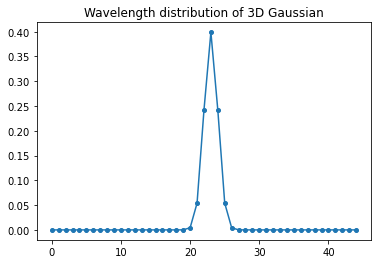

ValueError: too many values to unpack (expected 2)

In [268]:
# Plot wavelength distributions

# 3D Gaussian
g3_wavelength_proj = g3d.sum(dim=(0,1)).detach()
plt.plot(g3_wavelength_proj, marker='o', markersize=4)
plt.title("Wavelength distribution of 3D Gaussian")
plt.show()

# Wavelength filter
_, gaus_lam = gp.createWVFilt(mul, sigl, NL, m)
plt.plot(gaus_lam, marker='o', markersize=4)
plt.title("Wavelength distribution of weighting applied to filter array")
plt.show()

### Check phasor

In [426]:
importlib.reload(gp)

<module 'gaussplat' from '../Libraries/gaussplat.py'>

In [427]:
# 3D Gaussian
muy = 8.
mux = 0.
mul = 0.
sigy = 10.
sigx = 10.
sigl = 1.
NY, NX, NL = m.shape

# Create gaussian object and 2D array
g_test = gp.GaussObject(muy,mux,mul,sigy,sigx,sigl)
[x,y,coords] = gp.createMeshGrid(NX, NY)
g_test_vals = g_test.computeValues(coords, NY, NX)

# Create phasor and phase ramp of gaussian object
phasor_test, phaseramp_test = gp.createPhasor(x+1.1,y,g_test.mux,g_test.muy)

# Compute phasor using pixelated array
g_test_vals_f = torch.fft.fftshift(torch.fft.fft2(g_test_vals))
g_test_vals_phasor = torch.angle(g_test_vals_f).detach().numpy()

In [428]:
phaseramp_test.shape

torch.Size([620, 840])

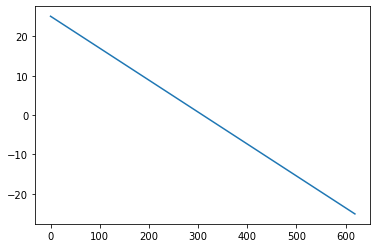

In [429]:
plt.plot(phaseramp_test[:,1].detach().numpy())

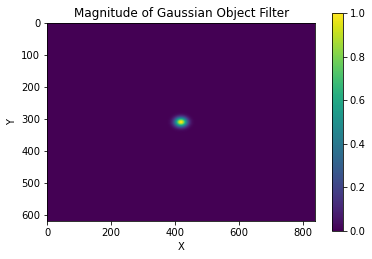

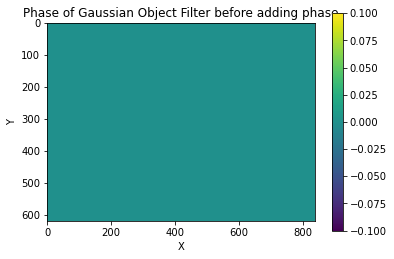

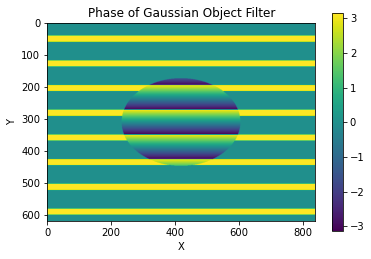

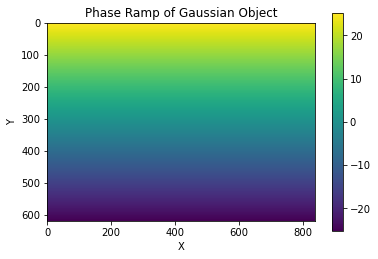

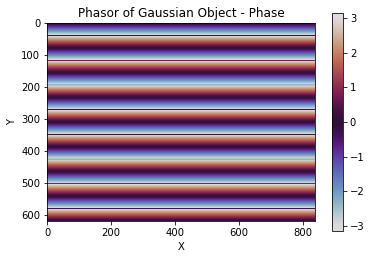

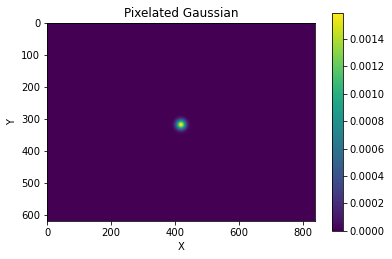

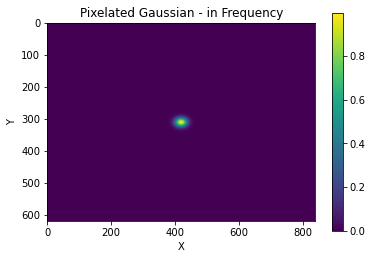

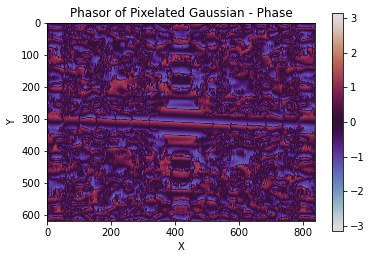

In [430]:
gauss_f_values_test = gp.createGaussFilter(g_test.covariancematrix, coords, NX, NY, g_test.amplitude)
gauss_f_test = gauss_f_values_test * phasor_test

plt.figure()
plt.imshow(np.abs(gauss_f_test.detach().numpy()))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Magnitude of Gaussian Object Filter')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.angle(gauss_f_values_test.detach().numpy()))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Phase of Gaussian Object Filter before adding phase')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.angle(gauss_f_test.detach().numpy()))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Phase of Gaussian Object Filter')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(phaseramp_test.detach().numpy())
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Phase Ramp of Gaussian Object')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.angle(phasor_test.detach().numpy()), cmap='twilight')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Phasor of Gaussian Object - Phase')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(g_test_vals.detach().numpy())
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Pixelated Gaussian')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(np.abs(g_test_vals_f.detach().numpy()))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Pixelated Gaussian - in Frequency')
plt.colorbar()
plt.show()

plt.figure()
plt.imshow(g_test_vals_phasor, cmap='twilight')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Phasor of Pixelated Gaussian - Phase')
plt.colorbar()
plt.show()

In [277]:
importlib.reload(gp)

<module 'gaussplat' from '../Libraries/gaussplat.py'>

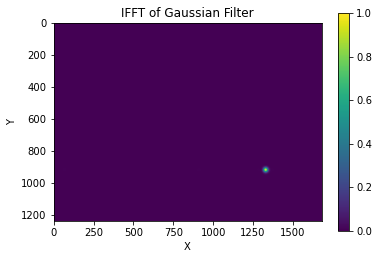

In [280]:
gauss_f_test_ifft = torch.fft.fftshift(torch.fft.ifft2(gauss_f_test,dim=(0,1)))
gauss_f_test_ifft = gauss_f_test_ifft/torch.amax(torch.abs(gauss_f_test_ifft))

plt.figure()
plt.imshow(torch.abs(gauss_f_test_ifft.detach()))
plt.xlabel('X')
plt.ylabel('Y')
plt.title('IFFT of Gaussian Filter')
plt.colorbar()
plt.show()